# Example: Linear Graph Dynamics - Part 2/2

- Author: Dr. Daning Huang
- Date: 10/28/2025
- Updated: 12/08/2025

## Introduction

In part 1 of the example, we showed using GNN as the autoencoder.  In this part, we will turn to the case of GNN as dynamics.

To make the discussion tangible, let's consider one simple dynamics:

$$
x_i^{t+1} = \alpha\sum_{j\in N_i^t} w_{ij}^t x_j^t
$$

where $x_i^t$ is the state of node $i$, $w_{ij}^t$ is the weight between nodes $i$ and $j$, and $N_i^t$ contains the neighbors of node $i$; the superscript $t$ indicates quantities at time $t$.  The weights $w_{ij}^t$ are known and the scaling factor $\alpha$ is unknown.

One can also write the dynamics at the graph level,

$$
x^{t+1} = \alpha W^t x^t
$$

where $W^t$ is the (weighted) adjacency matrix of the graph.  If one knows $W^t$, then it is natural thought to try to incorporate this information in the model and its training.

> In fact, in this case, knowing $W^t$, one could just fit $\alpha$ by linear regression.

If one is to use a generic NN to fit the model, it would be

$$
x^{t+1} = f_{NN}(x^t, W^t)
$$

But -

- Usually $W^t$ is large, and directly inputing $W^t$ to NN would dramatically increase the model size and be memory consuming.
- $W^t$ is typically sparse, and one could store it in a compact sparse format (e.g., COO or CSR), whose size depends on the number of edges $|E|$.  However, with chaning topology, $|E|$ would change, and this creates nuance in defining a vanilla NN model.

## Problem Setup

The data generation is done in a separate script in the repo (`scripts/ltg_dt_tv/gen_data.py`).  Here we directly load the data files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import DLDMG
from dymad.training import NODETrainer
from dymad.utils import plot_summary, plot_trajectory

First is topology.  Here we consider a 6-state system, and the adjacency matrices are plotted below.  Every two states are strongly coupled (bright color), and among the two-state groups the interaction is weaker.  Three topologies are considered: #2 and #3 each removes one edge from #1.

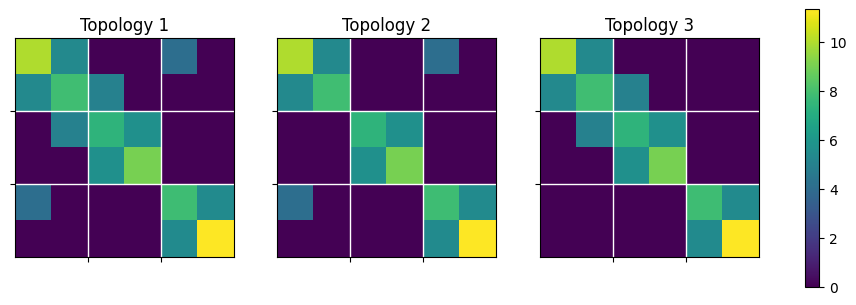

In [2]:
data = np.load(f'./data/topology_n2_s3_k4_s10.npz')
AAs = data["AAs"]
nSubSys = 3
nStates = 2

vmn1, vmx1 = np.min(AAs[0]), np.max(AAs[0])
tcks = np.arange(nStates, nSubSys*nStates, nStates)-0.5
f, ax = plt.subplots(1, nSubSys, figsize=(4*nSubSys,4))
for n in range(nSubSys):
    im0 = ax[n].imshow(AAs[n], vmin=vmn1, vmax=vmx1)
    ax[n].set_title(f'Topology {n+1}')
    ax[n].set_xticks(tcks)
    ax[n].set_yticks(tcks)
    ax[n].grid(which='both', color='white', linewidth=1.0)
    ax[n].set_xticklabels([])
    ax[n].set_yticklabels([])
cbar = f.colorbar(im0, ax=ax.tolist(), shrink=0.9, orientation='vertical');

In training, the topology randomly switches every 10 steps, which changes the dynamics.  As a result, the responses are non-smooth at topology switch.  In the topology plot, we are showing the sum of edge indices to indicate different topologies.

In testing, the topology will randomly switch every 5 steps (shown later).

In [3]:
data_trn = './data/data_n2_s3_k4_s10.pkl'
data_tst = './data/data_n2_s3_k4_s20.pkl'

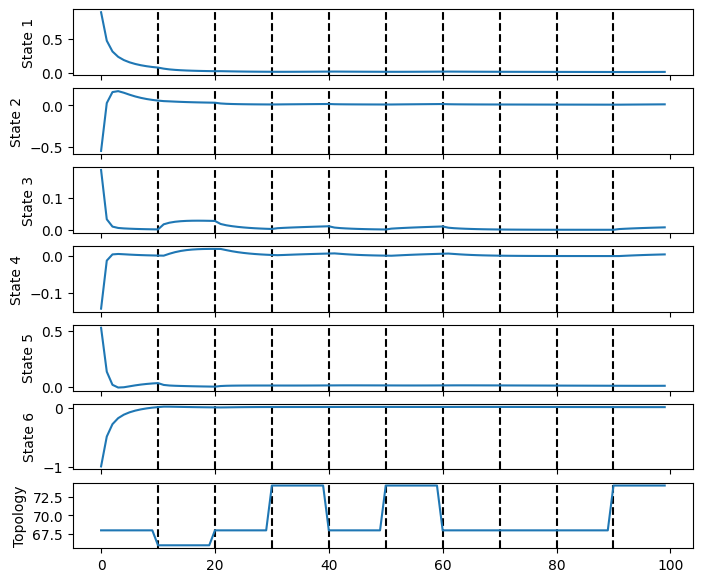

In [4]:
data = np.load(data_trn, allow_pickle=True)
tdx = 10
xs = data['x'][tdx]
ei = data['ei'][tdx]
Aidx = [np.sum(e) for e in ei]

Nt, Nx = xs.shape
T = np.arange(Nt)

f, ax = plt.subplots(Nx+1, 1, sharex=True, figsize=(8,Nx+1))
tdx = np.arange(1, 10) * 10
for n in range(Nx+1):
    for t in tdx:
        ax[n].axvline(t, color='k', linestyle='--')
for n in range(Nx):
    ax[n].plot(xs[:,n], label=f'SubSys {n+1}')
    ax[n].set_ylabel(f'State {n+1}')
ax[-1].plot(T, Aidx)
ax[-1].set_ylabel('Topology');

## Training and Results

Next we define the model and then train.  The graph convolution layer is chosen to be [GraphConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GraphConv.html); it is one simple GCL that multiplies weights to the inputs.

In [5]:
mdl_ld = {
    "name" : 'ltv_model',
    "encoder_layers" : 0,
    "decoder_layers" : 0,
    "processor_layers" : 1,
    "latent_dimension" : 2,   # Per node
    "gcl": "gcnv",            # GraphConv
    "gcl_opts":
        {"bias": False},      # Disable bias due to knowledge of problem
    "activation" : "none",    # Linear problem, so no nonlinearity
    "weight_init" : "xavier_uniform",
    "gain" : 0.01}            # Reduce gain to initialize to stable model

trn_nd = {
    "n_epochs": 200,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 1e-2,
    "decay_rate": 0.999,
    "sweep_lengths": [2, 4],
    "sweep_epoch_step": 100,
    "chop_mode": "unfold",
    "chop_step": 0.5,
    }

In the config YAML file, there is a new entry `transform_ew` that is for the data transformation of the edge weights.  In this simple problem, a vanilla Identity transformation is used.

In [ ]:
"""ltv_data.yaml
data:
  n_samples: 200
  n_steps: 100
  double_precision: true

transform_ew:
  type: "identity"

split:
  train_frac: 0.75

dataloader:
  batch_size: 64
"""

The following is the usual training procedure - nothing different from the non-graph model.

In [7]:
config_path = 'ltv_data.yaml'
config_mod = {
    "data": {"path": data_trn},
    "model": mdl_ld,
    "training" : trn_nd}

In [8]:
trainer = NODETrainer(config_path, DLDMG, config_mod=config_mod)
trainer.train();

And lastly plotting the results - nearly perfect match, even with a different frequency of topology variation.

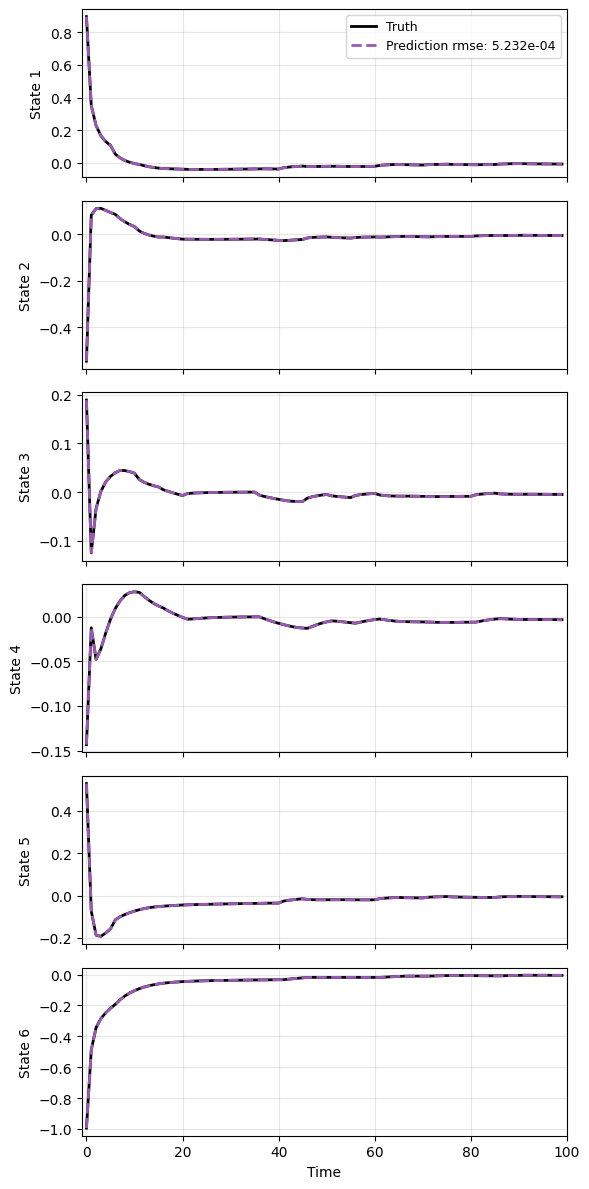

In [10]:
data = np.load(data_tst, allow_pickle=True)
tdx = 10
x_data = data['x'][tdx]
t_data = np.arange(0, x_data.shape[0])
ei_data = data['ei'][tdx]
ew_data = data['ew'][tdx]

res = [x_data]
with torch.no_grad():
    _, prd_func = load_model(DLDMG, 'ltv_model.pt')
    pred = prd_func(x_data, t_data, ei=ei_data, ew=ew_data)
    res.append(pred)

plot_trajectory(
    np.array(res), t_data, "LTGV",
    labels=['Truth', 'Prediction'], ifclose=False);